In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.insert(0, "..")
from classes.nn_classes import NNmodel
from classes.nn_classes import train_model as train_model_with_batch

In [2]:
def train_model(data_loader, model,optimizer, num_epochs=100, loss_func=torch.nn.CrossEntropyLoss()):
    for epoch in range(num_epochs):
        for features, labels in data_loader:
            optimizer.zero_grad()
            loss = loss_func(model.forward(features), labels)
            loss.backward()
            optimizer.step()

class CustomDataset(Dataset):
    def __init__(self, features, labels) -> None:
        super().__init__()
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]


def GaussDist(num_points, center, sigma):
    xy_gauss = torch.randn((num_points,2))*torch.sqrt(sigma) + center
    return xy_gauss

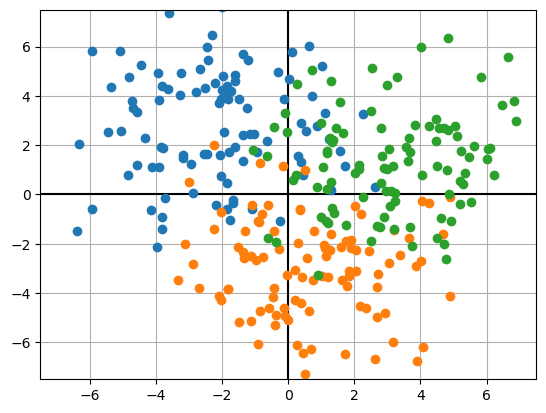

In [3]:
fig, ax = plt.subplots()
centers = [torch.tensor([-2.0,3.0]), torch.tensor([0.5,-3.0]), torch.tensor([3.0,1.0])]
data = torch.tensor([], dtype=torch.float)
labels = torch.tensor([], dtype=int)
for i, center in enumerate(centers):
    data = torch.cat((data, GaussDist(100, center=center, sigma=torch.tensor([2.0**2]))))
    labels = torch.cat((labels, i*torch.ones(100, dtype=int)))

train_data = CustomDataset(features=data, labels=labels)
train_loader = DataLoader(dataset=train_data, batch_size=len(train_data), shuffle=True)
ax.hlines(0, -10,10, colors="k")
ax.vlines(0, -10,10, colors="k")
ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])
with torch.no_grad():
    for label in range(3):
        indexes = torch.argwhere(train_data[:][1] == label)
        xy_points = train_data[:][0][indexes].squeeze(1)
        ax.plot(xy_points[:,0], xy_points[:,1], 'o')
ax.grid()

In [4]:
def lin_acc_func(x):
    return x

class predictModel(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def predict(self, x):
        return torch.argmax(self.softmax(self.forward(x=x)), dim=1)

model = predictModel(input_dim=2, output_dim=3, num_hidden_layers=1, dim_hiddens=8, activation_func=lin_acc_func, bias=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
train_model(data_loader=train_loader, model=model, optimizer=optimizer, num_epochs=10000, loss_func=torch.nn.CrossEntropyLoss())

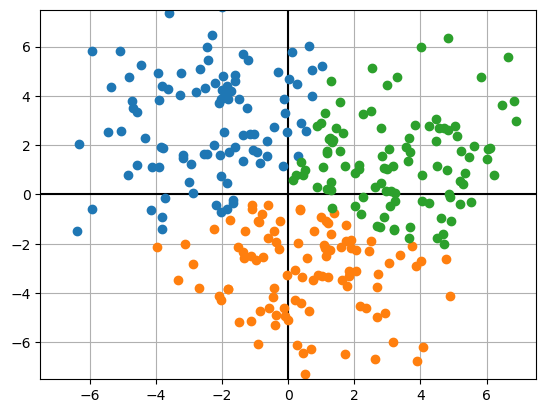

In [5]:
fig, ax = plt.subplots()
ax.hlines(0, -10,10, colors="k")
ax.vlines(0, -10,10, colors="k")
ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])
pred_labels = model.predict(train_data[:][0])
with torch.no_grad():
    for label in range(3):
        indexes = torch.argwhere(pred_labels == label)
        xy_points = train_data[:][0][indexes].squeeze(1)
        ax.plot(xy_points[:,0], xy_points[:,1], 'o')
ax.grid()

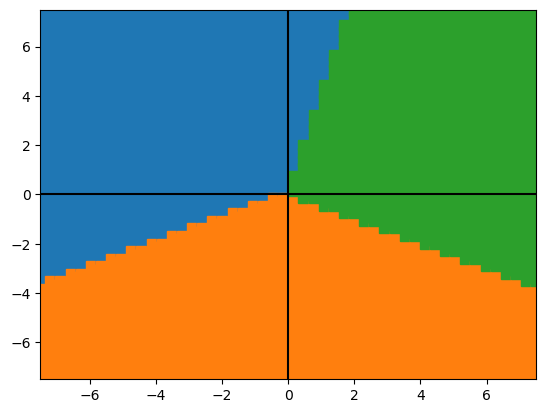

In [6]:
fig, ax = plt.subplots()
ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])

xy_vals = torch.linspace(-7.5, 7.5, 50)
with torch.no_grad():
    for xy_val in xy_vals:
        coloumn = torch.zeros((len(xy_vals), 2))
        coloumn[:,0]+=xy_val
        coloumn[:,1]+=xy_vals
        labels = model.predict(x=coloumn)
        for label in range(3):
            indexes = torch.argwhere(labels == label)
            xy_points = coloumn[indexes].squeeze(1)
            ax.plot(xy_points[:,0], xy_points[:,1], 's', c=f"C{label}", ms=6.5)
ax.grid()
ax.hlines(0, -10,10, colors="k")
ax.vlines(0, -10,10, colors="k")

In [7]:
class MyCustomData(Dataset):
    def __init__(self, xs_tens, l1=25.2, l2=300.0) -> None:
        super().__init__()
        self.l1 = l1
        self.l2 = l2
        self.xs_tens = xs_tens
        self.labels = self.labelling(f=self.f(self.xs_tens[:,0], self.xs_tens[:,1]))

    def labelling(self, f):
        labels = torch.ones(len(f), dtype=torch.long)
        low_indices = torch.argwhere(f < self.l1)
        labels[low_indices] = 0
        upper_indices = torch.argwhere(f > self.l2)
        labels[upper_indices] = 2
        return labels

    def f(self, x1, x2):
        t1 = (x1**2+x2-11.0)**2
        t2 = (x1+x2**2-7.0)**2
        return t1 + t2
    
    def __getitem__(self, index):
        return self.xs_tens[index], self.labels[index]
    
    def __len__(self):
        return len(self.xs_tens)

In [106]:
xps = torch.linspace(-7.0, 7.0, 50)
x1s, x2s = torch.meshgrid([xps, xps])
random_perm = torch.randperm(xps.size()[0])
x1s = x1s[random_perm]
x2s = x2s[random_perm]
xs_tens = torch.column_stack((x1s.view(-1,1),x2s.view(-1,1)))
total_dataset = MyCustomData(xs_tens=xs_tens)
train_dataset = MyCustomData(xs_tens[0:1999])
val_dataset = MyCustomData(xs_tens[1999:2249])
test_dataset = MyCustomData(xs_tens[2249:2499])

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)


torch.int64


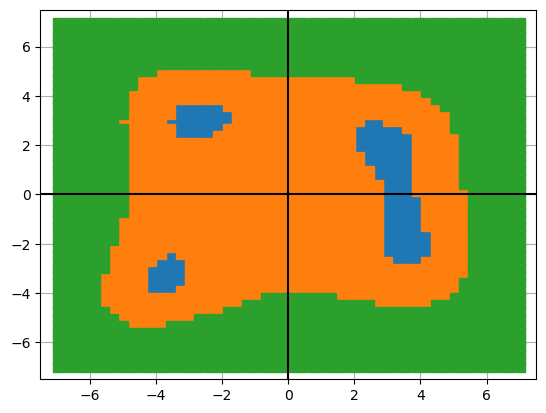

In [124]:
fig, ax = plt.subplots()
ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])

labels = total_dataset[:][1]
print((labels[0].dtype))
with torch.no_grad():
    for label in range(3):
        indexes = torch.argwhere(labels == label)
        all_data = total_dataset[indexes]
        plot_points = all_data[:][0].squeeze(1)
        ax.plot(plot_points[:,0], plot_points[:,1], 's', c=f"C{label}", ms=6.48, alpha=1.0)
ax.grid(visible=True)
ax.hlines(0, -10,10, colors="k")
ax.vlines(0, -10,10, colors="k")

In [130]:
class DirectModel(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.l1 = torch.nn.Linear(2, 3, bias=True)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.l1(x)
    
    def predict(self, x):
        return torch.argmax(self.softmax(self.forward(x)), dim=1)

model = DirectModel()

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
train_losses, val_losses = train_model_with_batch(epochs=1000, model=model, 
                                                  train_loader=train_loader, 
                                                  val_loader=val_loader,
                                                  optimizer=optimizer,
                                                  early_stopping=True,
                                                  patience=100,
                                                  loss_func=torch.nn.CrossEntropyLoss())

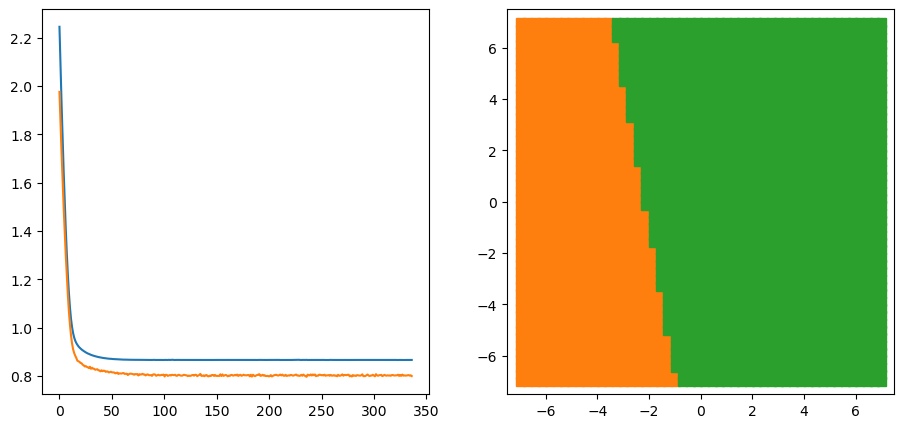

In [131]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
epochs = torch.linspace(0.0, len(val_losses), len(val_losses))
labels = model.predict(x=xs_tens)
axs[1].set_xlim([-7.5,7.5])
axs[1].set_ylim([-7.5,7.5])

with torch.no_grad():
    axs[0].plot(epochs, train_losses)
    axs[0].plot(epochs, val_losses)
    for label in range(3):
        indices = torch.argwhere(labels == label)
        xs_plot = xs_tens[indices].squeeze(1)
        axs[1].plot(xs_plot[:,0], xs_plot[:,1], 's', c=f"C{label}", ms=6.48, alpha=1.0)

In [125]:
model = predictModel(input_dim=2, output_dim=3, num_hidden_layers=1, dim_hiddens=10, activation_func=torch.nn.SiLU(), bias=True)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
train_losses, val_losses = train_model_with_batch(epochs=1000, model=model, 
                                                  train_loader=train_loader, 
                                                  val_loader=val_loader,
                                                  optimizer=optimizer,
                                                  early_stopping=True,
                                                  patience=100,
                                                  loss_func=torch.nn.CrossEntropyLoss())

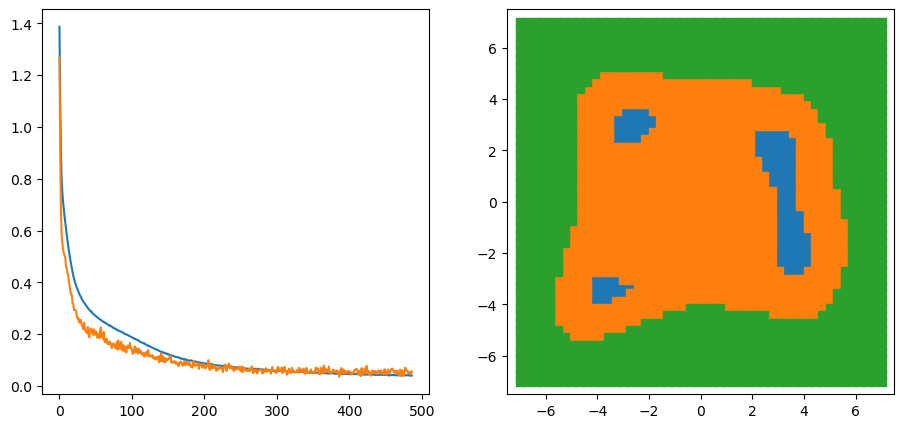

In [127]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
epochs = torch.linspace(0.0, len(val_losses), len(val_losses))
labels = model.predict(x=xs_tens)
axs[1].set_xlim([-7.5,7.5])
axs[1].set_ylim([-7.5,7.5])

with torch.no_grad():
    axs[0].plot(epochs, train_losses)
    axs[0].plot(epochs, val_losses)
    for label in range(3):
        indices = torch.argwhere(labels == label)
        xs_plot = xs_tens[indices].squeeze(1)
        axs[1].plot(xs_plot[:,0], xs_plot[:,1], 's', c=f"C{label}", ms=6.48, alpha=1.0)

In [128]:
model = predictModel(input_dim=2, output_dim=3, num_hidden_layers=2, dim_hiddens=10, activation_func=torch.nn.SiLU(), bias=True)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
train_losses, val_losses = train_model_with_batch(epochs=1000, model=model, 
                                                  train_loader=train_loader, 
                                                  val_loader=val_loader,
                                                  optimizer=optimizer,
                                                  early_stopping=True,
                                                  patience=100,
                                                  loss_func=torch.nn.CrossEntropyLoss())

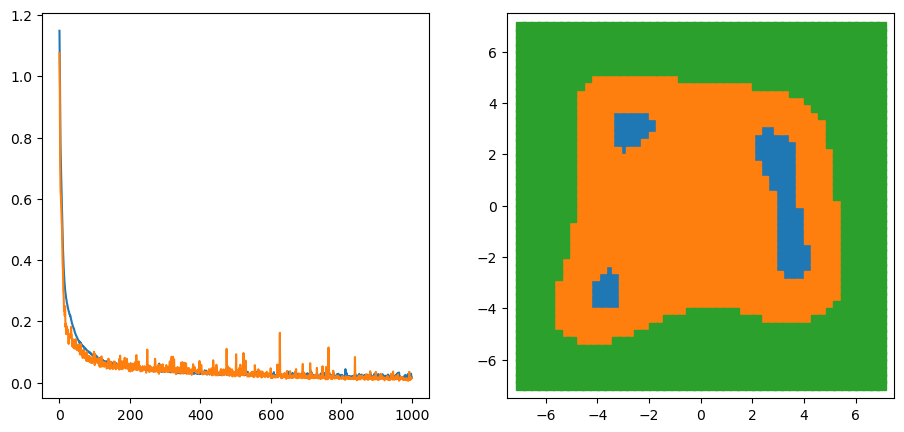

In [129]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
epochs = torch.linspace(0.0, len(val_losses), len(val_losses))
labels = model.predict(x=xs_tens)
axs[1].set_xlim([-7.5,7.5])
axs[1].set_ylim([-7.5,7.5])

with torch.no_grad():
    axs[0].plot(epochs, train_losses)
    axs[0].plot(epochs, val_losses)
    for label in range(3):
        indices = torch.argwhere(labels == label)
        xs_plot = xs_tens[indices].squeeze(1)
        axs[1].plot(xs_plot[:,0], xs_plot[:,1], 's', c=f"C{label}", ms=6.48, alpha=1.0)